# Read in Word Doc

Grab the text from a word document

In [1]:
import re
from typing import Callable
from functools import reduce, partial

from docx import Document
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

Util functions

In [2]:
def pipeline(*functions: Callable) -> Callable:
    '''
    create a callable pipeline of functions; 
    functions f, g,...n become a single callable of  n(...(g(f(x))))
    '''
    return reduce(lambda f, g: lambda x: g(f(x)), functions)

def flatten(x: list) -> list:
    return sum(map(flatten, x), []) if isinstance(x, list) else [x]


def clean(text: str) -> list[str]:
    # pipeline funcs
    tokenize = lambda x: nltk.word_tokenize(x)
    
    # regexes
    url_re = lambda s: s if s and re.match(('(https?:\/\/)?([\w\-])+\.{1}'
                                         '([a-zA-Z]{2,63})([\/\w-]*)*\/?\??'
                                         '([^#\n\r]*)?#?([^\n\r]*)'), s) is None else "URL"
    uname_re = lambda s: s if s and re.match(r'^@\S+', s) is None else "SCREEN_NAME"
    hashtag_re = lambda s: s if s and re.match(r'^#\S+', s) is None else "HASHTAG"
    
    # filters/maps
    url = lambda x: map(url_re, x)
    uname = lambda x: map(uname_re, x)
    hashtag = lambda x: map(hashtag_re, x)
    lower = lambda x: map(lambda s: s.lower(), x)
    len_4 = lambda x: filter(lambda wd: len(wd) > 4, x)
    #frontslash = lambda x: map(lambda s: s.split('/'), x) # this is dumb
    
    f = pipeline(tokenize, lower, url, uname, hashtag, len_4)
    
    return list(f(text))
    
def lemmatize(tokens: list[str]) -> list[str]:
    # whole-token related
    en_stop = lambda x: filter(lambda wd: wd not in stopwords.words('english'), x)
    lemmywinks = lambda x: map(lambda wd: wn.morphy(wd) or wd, x)
        
    f = pipeline(en_stop, lemmywinks)
    
    return list(f(tokens))

def get_document_words(path: str) -> list[str]:
    'get the words from a word document and return as a list of tokens'
       
    doc = Document(path)
    
    lines = [list(clean(para.text)) for para in doc.paragraphs]
    
    return list(lemmatize(flatten(lines)))

In [34]:
wn.morphy("aardvarks")

'aardvark'

In [3]:
get_document_words("Luke Chambers FT Resume RES-2020-00386.docx")[5:25]

['discovery',
 'analyst/linguist',
 'thirteen',
 'years',
 'experience',
 'analysis/engineering',
 'science',
 'experience',
 'multiple',
 'programming',
 'language',
 'daily',
 'usage',
 'agency',
 'tool',
 'database',
 'professionalize',
 'chinese',
 'linguist',
 'instructor']

# Exploring the Data

the data set is labeled!

In [4]:
import pandas as pd

df = pd.read_csv('UpdatedResumeDataSet.csv')

In [5]:
df.iloc[:500:50]

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
50,HR,SOFTWARE SKILLS: â¢ General Computer Proficie...
100,Advocate,Skills: Natural Languages: Proficient in Engli...
150,Web Designing,"Technical Skills Web Technologies: Angular JS,..."
200,Mechanical Engineer,Education Details \r\nMay 1999 to September 20...
250,Sales,Education Details \r\n Bachelor's \r\n Bache...
300,Civil Engineer,PERSONAL SKILLS â¢ Passionate towards learnin...
350,Java Developer,TECHNICAL STRENGTHS Computer Language Java/J2E...
400,Java Developer,TECHNICAL SKILLS Programming Languages: Java (...
450,SAP Developer,Competencies: SAP Business Intelligence Versio...


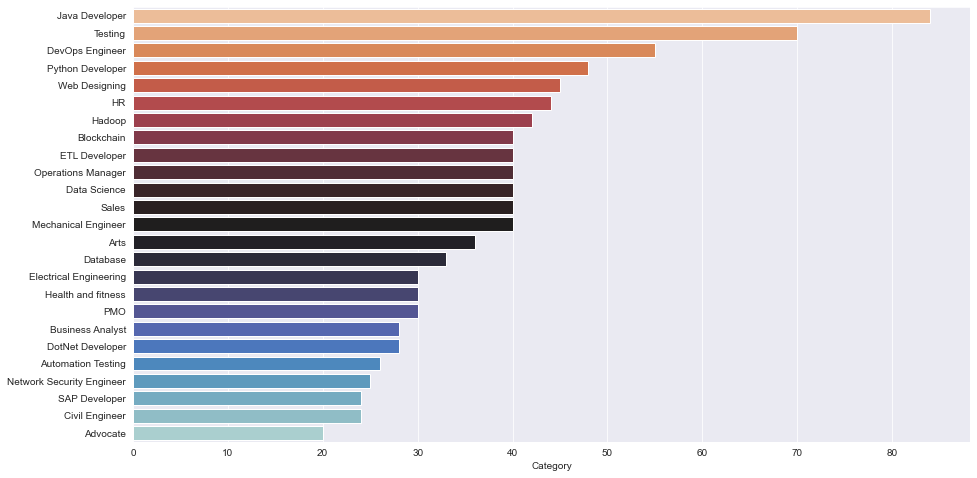

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(15,8))
sns.barplot(x=df['Category'].value_counts(),
            y=df['Category'].value_counts().index,
            palette='icefire_r');


# Topic Modeling

In [7]:
def prep_text(text: str) -> list[str]:
    tokens = clean(text)
    return lemmatize(tokens)

In [8]:
import tqdm.notebook

text_data = []
for text in tqdm.notebook.tqdm_notebook(df['Resume']):
    text_data.append(prep_text(text))

  0%|          | 0/962 [00:00<?, ?it/s]

Create dictionary and corpus from the resume text data -- resumable from here for time's sake.

In [9]:
from gensim import corpora

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [ ]:
import pickle

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Convenience cell for reload on restart

In [ ]:
#import os, pickle

#if not globals().get('dictionary'):
#    if os.path.exists('corpus.pkl') and os.path.exists('dictionary.gensim'):
#        corpus = pickle.load(open('corpus.pkl', 'rb'))
#        dictionary = corpora.Dictionary().load("dictionary.gensim")

Train the model

In [10]:
import gensim

NUM_TOPICS = len(df['Category'].unique())

lda_model = gensim.models.ldamodel.LdaModel(
    corpus,
    num_topics=12,
    id2word=dictionary,
    passes=20
)

In [14]:
topics = lda_model.print_topics(num_words=5)
for topic in sorted(topics, key=lambda k: k[0]):
    print(topic)

(0, '0.022*"project" + 0.020*"testing" + 0.016*"system" + 0.015*"client" + 0.012*"automation"')
(1, '0.026*"management" + 0.024*"report" + 0.022*"project" + 0.014*"hadoop" + 0.013*"maintain"')
(2, '0.035*"exprience" + 0.031*"month" + 0.022*"details" + 0.022*"technology" + 0.021*"developer"')
(3, '0.024*"project" + 0.020*"description" + 0.017*"company" + 0.014*"system" + 0.013*"application"')
(4, '0.021*"exprience" + 0.019*"details" + 0.019*"company" + 0.018*"sales" + 0.018*"description"')
(5, '0.021*"project" + 0.021*"company" + 0.019*"description" + 0.015*"check" + 0.014*"exprience"')
(6, '0.019*"server" + 0.018*"database" + 0.015*"project" + 0.011*"application" + 0.011*"script"')
(7, '0.027*"company" + 0.017*"operations" + 0.014*"customer" + 0.014*"ensure" + 0.011*"description"')
(8, '0.037*"exprience" + 0.034*"month" + 0.019*"details" + 0.017*"project" + 0.016*"skill"')
(9, '0.025*"exprience" + 0.024*"month" + 0.014*"project" + 0.014*"testing" + 0.012*"business"')
(10, '0.027*"detai

What topic is *my* resume?

In [12]:
new_doc = get_document_words('Luke Chambers FT Resume RES-2020-00386.docx')

new_doc_bow =dictionary.doc2bow(new_doc)

In [13]:
sorted(lda_model.get_document_topics(new_doc_bow), key=lambda k: k[1], reverse=True)

[(9, 0.16552496),
 (8, 0.15416363),
 (3, 0.11446676),
 (10, 0.11259291),
 (6, 0.11174489),
 (7, 0.10952158),
 (2, 0.10307919),
 (5, 0.04947491),
 (1, 0.03401808),
 (11, 0.03206822),
 (0, 0.013160297)]

# Mentioning ATB

just for funzies

In [15]:
from ATB.atb import ATB

atb = ATB()

In [16]:
import re
import json

def make_vocabulary() -> set:
    '''
    Create a term vocabulary for ingest and comparisons
    '''
    words = {w for word in open('words.txt', 'r').readlines()
            if (w:=re.sub('[\W]+', '', word.strip().lower()))}

    packs = {d.get('project').lower()
             for d in json.loads(open('pypi.json').read())['rows']}
    packs = packs.union({t.strip().lower()
                         for t in json.loads(open('technicalterms.json').read())})
    for pack in packs:
        words.add(pack)
    
    return words

In [17]:
words = make_vocabulary()

In [18]:
import tqdm.notebook
for word in tqdm.notebook.tqdm_notebook(words):
    atb.insert(word, True)

  0%|          | 0/460459 [00:00<?, ?it/s]

In [19]:
atb.dijkstra_segment("squashedtogetherwords")

['squashed', 'together', 'words']

# Make a Classifier 

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
label = LabelEncoder()

df['cat'] = label.fit_transform(df['Category'])
df['clean'] = [" ".join(thing) for thing in text_data]

df.head()

,Category,Resume,cat,clean
0,Data Science,Skills * Programming Languages: Python (pandas...,6,skill programming language python panda numpy ...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,6,education details uit-rgpv scientist scientist...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",6,area interest learning control system design p...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,6,skill python tableau lumira linear programming...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",6,education details ymcaust faridabad haryana sc...


In [22]:
text = df['clean'].values
target = df['cat'].values

In [23]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500,
)
word_vectorizer.fit(text)

TfidfVectorizer(max_features=1500, stop_words='english', sublinear_tf=True)

In [24]:
features = word_vectorizer.transform(text)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=5, test_size=0.2)

In [26]:
model = OneVsRestClassifier(KNeighborsClassifier())
model.fit(x_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [27]:
y_pred = model.predict(features)

In [28]:
print(f'  Training Accuracy: {model.score(x_train, y_train):.2%}')
print(f'Validation Accuracy: {model.score(x_test, y_test):.2%}')

  Training Accuracy: 99.09%
Validation Accuracy: 97.41%


# ...And a GUI because why not

In [29]:
import ipywidgets as wid

In [30]:
from IPython.display import display

paste_area = wid.Textarea(layout={'height': '300px', 'width':'75%'})
butt = wid.Button(description = 'Classify')
out = wid.Output(layout={'height':'100px',
                         'width':'75%',
                         'margin': '50px auto',
                         'border':'1px solid darkgrey'})

@out.capture()
def click(context) -> None:
    text = ' '.join(prep_text(paste_area.value))
    text_features = word_vectorizer.transform([text])
    result = model.predict(text_features)
    print("Resume classification:", end=' ')
    print(label.inverse_transform(result)[0])
        

butt.on_click(click)
        
box = wid.VBox(children=[
    wid.Label('Paste Resume Text into this area and hit the button!'),
    paste_area,
    butt,
    out
], layout={'display': 'flex',
           'flex_flow':'column',
           'align_items':'center'})

box

In [31]:
doc = " ".join(get_document_words("Luke Chambers FT Resume RES-2020-00386.docx"))
doc_features = word_vectorizer.transform([doc])
result = model.predict(doc_features)

label.inverse_transform(result)[0]

'Data Science'